In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore')
palette = sns.husl_palette(s=1)
sns.set(style='whitegrid', palette=palette, context='talk')

### Load data

In [242]:
df = pd.read_csv('train.csv', parse_dates=True)
X_test = pd.read_csv('test.csv', parse_dates=True)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [243]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Feature Engineering Function

In [124]:
def feat_eng(X):
    # Create additional features
    X_t = X
    X_t['atemp_shift'] = abs(X_t['atemp'] - 35)
    X_t['datetime'] = pd.to_datetime(X_t['datetime'])
    # Extract all time information
    X_t['datetime_hour'] = X_t['datetime'].dt.hour # important _ onehot
    X_t['datetime_day'] = X_t['datetime'].dt.day
    X_t['datetime_month'] = X_t['datetime'].dt.month # use month as onehot or factorized instead of season
    X_t['datetime_year'] = X_t['datetime'].dt.year # maybe instead of timestamp
    X_t['datetime_weekdays'] = X['datetime'].dt.day_name()
    X_t['timestamp'] = X_t['datetime'].astype(int) / 1_000_000_000_000_000_000
    X_t['hour_workday'] = X_t['datetime_hour'] * X_t['workingday']
    X_t['hour_weekend'] = X_t['datetime_hour'] * (X_t['workingday'] - 1) * (-1)
    return X_t

### Train-test-split

In [244]:
X = df.copy()#.reset_index(inplace=True)
y = df['count'].values

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

X_train.reset_index(inplace=True)
X_val.reset_index(inplace=True)

y_train_cas = X_train['casual']
y_train_reg = X_train['registered']

In [246]:
# Feature Engineer
X_train = feat_eng(X_train)
X_val = feat_eng(X_val)
X_test = feat_eng(X_test)

In [247]:
# One-Hot-Encoding
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder(sparse=False, drop='first')
onehot_features = ['datetime_month', 'weather', 'hour_workday', 'hour_weekend']
ohc.fit(X_train[onehot_features])
onehot_columns = ohc.get_feature_names(['month', 'weather', 'hour_workday', 'hour_weekend'])

# Make dataframes of one-hot-encoded features and give column names
X_train_onehot = ohc.transform(X_train[onehot_features])
X_train_onehot = pd.DataFrame(X_train_onehot, columns=onehot_columns)

X_val_onehot = ohc.transform(X_val[onehot_features])
X_val_onehot = pd.DataFrame(X_val_onehot, columns=onehot_columns)

X_test_onehot = ohc.transform(X_test[onehot_features])
X_test_onehot = pd.DataFrame(X_test_onehot, columns=onehot_columns)

In [248]:
# Select features from original data and concatenate with one-hot-encoded features
features = ['timestamp', 'workingday', 'atemp_shift', 'humidity', 'windspeed']

X_train = X_train[features]
X_train = pd.concat([X_train, X_train_onehot], axis=1)

X_val = X_val[features]
X_val = pd.concat([X_val, X_val_onehot], axis=1)

X_test = X_test[features]
X_test = pd.concat([X_test, X_test_onehot], axis=1)

## Set up the model

In [217]:
from sklearn.linear_model import LinearRegression

In [218]:
lr_cas = LinearRegression()
lr_cas.fit(X_train, np.log(y_train_cas+1))
lr_cas.score(X_train, np.log(y_train_cas+1))

0.8568524428875476

In [219]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, np.log(y_train_reg+1))
lr_reg.score(X_train, np.log(y_train_reg+1))

0.9410294346078034

Cross validation

In [220]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_reg, X_train, np.log(y_train_reg+1), cv=4, scoring='r2')
scores

array([-2.75996060e+15,  9.39320582e-01,  9.35972017e-01,  9.39381715e-01])

In [221]:
scores.mean().round(3), scores.std().round(3)

(-689990149434105.9, 1195097995541915.0)

In [222]:
y_pred_cas = np.exp(lr_cas.predict(X_train))
y_pred_reg = np.exp(lr_reg.predict(X_train))
y_pred_count = y_pred_cas + y_pred_reg

In [254]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

print('Score for training data')
print('R2 value: ' + str(r2_score(y_train, y_pred_count)))
print('RMSLE: ' + str(np.sqrt(mean_squared_log_error(y_train, y_pred_count))))

Score for training data
R2 value: 0.9069097156795476
RMSLE: 0.35801605974064016


In [225]:
lr_reg.coef_, lr_cas.coef_

(array([ 1.63515526e+01, -1.01525796e+00, -2.08610781e-02, -2.12631461e-03,
        -2.95997454e-03,  9.62853276e-02,  8.09195460e-02,  1.94260144e-01,
         4.01304054e-01,  3.57353610e-01,  2.32669775e-01,  2.23984059e-01,
         2.24002743e-01,  3.12031612e-01,  2.62495490e-01,  2.07695018e-01,
        -7.28390757e-02, -5.33478887e-01, -4.64339493e-01, -7.74474091e-01,
        -1.39632578e+00, -1.71221661e+00, -1.60258674e+00, -1.33885508e-01,
         1.32847883e+00,  2.34963887e+00,  2.87045353e+00,  2.12021121e+00,
         1.34894580e+00,  1.44201342e+00,  1.69101577e+00,  1.64645033e+00,
         1.50555292e+00,  1.62499552e+00,  2.07485120e+00,  2.76641793e+00,
         2.71987665e+00,  2.33682551e+00,  2.00842868e+00,  1.73441222e+00,
         1.41794053e+00,  9.58806661e-01, -2.48336947e-01, -5.43555942e-01,
        -1.34232042e+00, -2.38834097e+00, -2.28023872e+00, -1.68819625e+00,
        -7.74952865e-01,  1.28639308e-01,  5.00967498e-01,  8.27272539e-01,
         9.8

In [226]:
count_residual = y_pred_count - y_train

In [227]:
result = pd.DataFrame({'y_train':y_train, 'y_pred_count':y_pred_count, 'ycount_residual':count_residual})

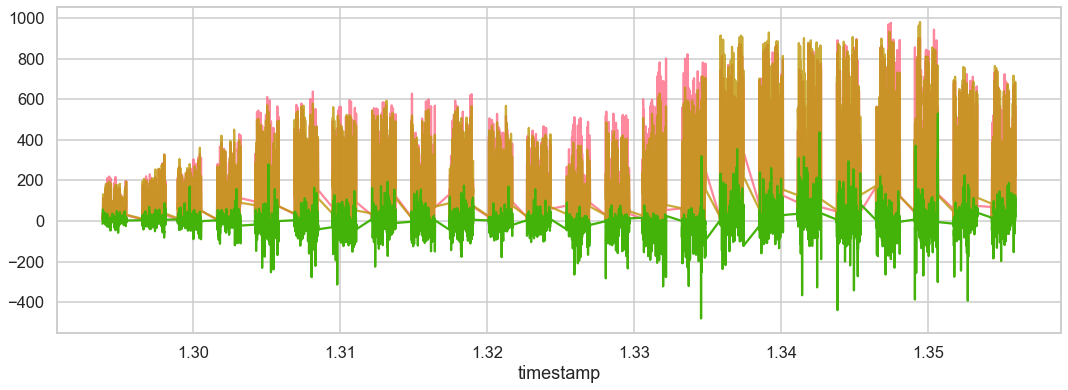

In [228]:
fig = plt.figure(figsize=(18,6))
ax = sns.lineplot(x='timestamp', y=y_train, data=X_train, alpha = 0.8)
ax = sns.lineplot(x='timestamp', y=y_pred_count, data=X_train, alpha = 0.8)
ax = sns.lineplot(x='timestamp', y=count_residual, data=X_train)
#ax.set_xlim(pd.Timestamp('2011-04-01'), pd.Timestamp('2011-09-01'))

In [33]:
X_train['count_residual'].min(), X_train['count_residual'].max(),  X_train['count_residual'].isna().sum()

(-481.3880829713653, 519.8977275006296, 0)

In [229]:
y_train

array([166, 157, 220, ..., 334, 131,  99])

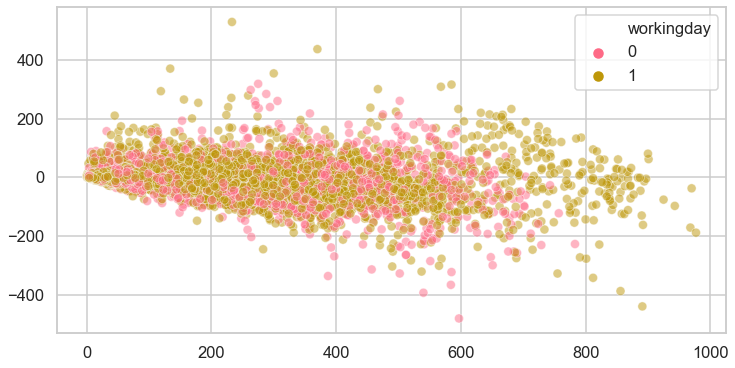

In [231]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x=y_train, y=count_residual, hue='workingday', data=X_train, alpha = 0.5)

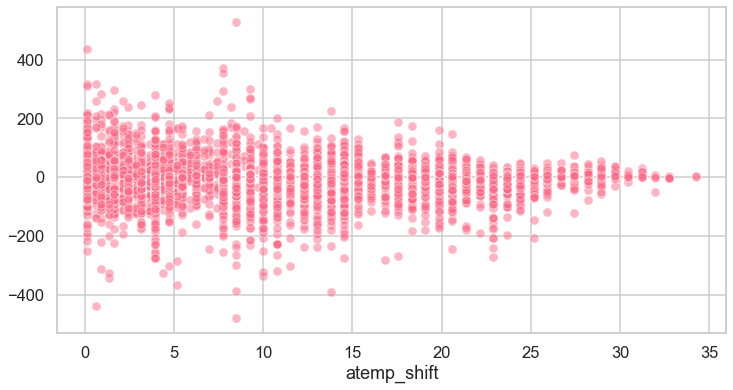

In [234]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='atemp_shift', y=count_residual, data=X_train, alpha = 0.5)

In [236]:
X_train[count_residual > 300]

,timestamp,workingday,atemp_shift,humidity,windspeed,month_2,month_3,month_4,month_5,month_6,...,hour_weekend_14,hour_weekend_15,hour_weekend_16,hour_weekend_17,hour_weekend_18,hour_weekend_19,hour_weekend_20,hour_weekend_21,hour_weekend_22,hour_weekend_23
139,1.342631,1,0.150,70,16.9979,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3234,1.350670,1,8.485,83,7.0015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4801,1.341562,1,0.605,41,11.0014,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5456,1.349165,1,7.725,88,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7153,1.337018,1,7.725,83,0.0000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7183,1.334588,0,0.150,33,30.0026,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,1.341216,1,0.150,52,12.9980,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8653,1.350634,1,9.240,94,7.0015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [255]:
# Score on validation data!

y_pred_cas_val = np.exp(lr_cas.predict(X_val))
y_pred_reg_val = np.exp(lr_reg.predict(X_val))
y_pred_count_val = y_pred_cas_val + y_pred_reg_val

print('Score for validation data')
print('R2 value: ' + str(r2_score(y_val, y_pred_count_val)))
print('RMSLE: ' + str(np.sqrt(mean_squared_log_error(y_val, y_pred_count_val))))

Score for validation data
R2 value: 0.9094347611296428
RMSLE: 0.37360451222782737


#### Scale the data

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # scales each column to minimum 0.0 and maximum 1.0. Makes sure all data fits together.
scaler.fit(X_train)

X_train = scaler.transform(X_train) # later just use transform on X_test, DO NOT FIT AGAIN
X_val = scaler.transform(X_val)

X_train.head()#.shape, X_val.shape

AttributeError: 'numpy.ndarray' object has no attribute 'head'